# **Breast Cancer Prediction**

## **Librerias**

In [1]:
!pip install bayesian-optimization==1.4.1

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [2]:
!pip install keras==2.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.11.0 which is incompatible.


In [222]:
import pickle
import pandas as pd
import numpy as np
import os.path as osp
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn import set_config
set_config(display="diagram")
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import missingno as msno
from datetime import datetime
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [5]:
sns.set_style("white")

## **Carga de datos**

In [6]:
df = pd.read_parquet("/content/df_train.parquet")
df_test = pd.read_parquet("/content/df_test.parquet")
df

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6344,F,UL,1979-08-20,1223,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,Sin servicios nutricion
4050,F,SO,1973-07-19,1007,None,0,2.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sin servicios nutricion
1040,F,CA,1971-05-12,1008,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,Multiple servicio nutricion


## **Preprocesamiento**

**Nota:** Se llega a estos procesos durante el EDA.


In [7]:
def preprocesamiento_inicial(df_p: pd.DataFrame):
  df = df_p.copy()
  for column in ["CESION", "CANCER_MAMA_FAMILIAR","CANCER_OTRO_SITIO","CANCER_OTRO_SITIO_FAMILIAR","CEREBRAL_FAMILIAR"]:
    df[column] = df[column].astype('float')
  df['Edad'] = df['Fecha_cero'].dt.year - df['FECHA_NACIMIENTO'].dt.year
  del df['Fecha_cero']
  del df['CODIGO_SEDE']
  for column in ["FECHA_CONSULTA_TENSION","FECHA_NACIMIENTO","FECHA_DATOS_PESO_TALLA"]:
    del df[column]
  return df

In [9]:
df = preprocesamiento_inicial(df_p=df)

## **1. Entendimiento y Preparación de los datos**

> 1.1. Análisis estadístico y Outliers

> 1.2. Análisis de valores faltantes

> 1.3. Imputación de valores

> 1.4. Análisis de Baseline

### **1.1. Análisis estadístico y Outliers**

#### **1.1.1. Tipos de variables**

In [10]:
# Columnas
df.columns


Index(['GENERO', 'ESTADO_CIVIL', 'MULTI_CANCER', 'CESION', 'RIESGOS',
       'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR', 'PESO', 'TALLA',
       'TSISTOLICA', 'TDIASTOLICA', 'Target', 'mes_6', 'mes_5', 'mes_4',
       'mes_3', 'mes_2', 'mes_1', 'valor_servicio', 'IV_NIVEL',
       'HOSPI_NO_QUIRURGICA', 'URGENCIAS', 'HOSPITALIZACION',
       'CITA_ONCOLOGICA', 'Biopsias_cancer', 'radioterapias_cancer',
       'quimioterapias__cancer', 'hormonoterapias__cancer',
       'cuidado_palitiavo__cancer', 'inmunoterapias_cancer',
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer', 'atencion_nutricion', 'Edad'],
      dtype='object')

In [11]:
# Tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GENERO                      3955 non-null   object 
 1   ESTADO_CIVIL                3955 non-null   object 
 2   MULTI_CANCER                337 non-null    object 
 3   CESION                      3955 non-null   float64
 4   RIESGOS                     3955 non-null   float64
 5   CANCER_MAMA_FAMILIAR        3955 non-null   float64
 6   CANCER_OTRO_SITIO           3955 non-null   float64
 7   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   float64
 8   CEREBRAL_FAMILIAR           3955 non-null   float64
 9   PESO                        3822 non-null   float64
 10  TALLA                       3822 non-null   float64
 11  TSISTOLICA                  3815 non-null   float64
 12  TDIASTOLICA                 3815 non-null   float64
 13  Target                      3955 non

In [12]:
# Recuento unicos
df.nunique()

GENERO                           2
ESTADO_CIVIL                     5
MULTI_CANCER                     2
CESION                           2
RIESGOS                          9
CANCER_MAMA_FAMILIAR             2
CANCER_OTRO_SITIO                2
CANCER_OTRO_SITIO_FAMILIAR       2
CEREBRAL_FAMILIAR                2
PESO                           257
TALLA                           51
TSISTOLICA                      87
TDIASTOLICA                     56
Target                           2
mes_6                         1435
mes_5                         1550
mes_4                         1747
mes_3                         1720
mes_2                         1771
mes_1                         1789
valor_servicio                3575
IV_NIVEL                        59
HOSPI_NO_QUIRURGICA              9
URGENCIAS                        6
HOSPITALIZACION                  8
CITA_ONCOLOGICA                 15
Biopsias_cancer                 29
radioterapias_cancer             6
quimioterapias__canc

**Nota:** "CESION", "CANCER_MAMA_FAMILIAR","CANCER_OTRO_SITIO","CANCER_OTRO_SITIO_FAMILIAR","CEREBRAL_FAMILIAR" deben transformarse a Bool. Se debe excluir del análisis "Fecha_cero".

In [13]:
for column in ["CESION", "CANCER_MAMA_FAMILIAR","CANCER_OTRO_SITIO","CANCER_OTRO_SITIO_FAMILIAR","CEREBRAL_FAMILIAR"]:
  df[column] = df[column].astype('float')
  df_test[column] = df_test[column].astype('float')

#### **1.1.2. Análisis estadístico por tipo de variable**

##### **1.1.2.1. Outliers y Análisis Variables númericas**

In [14]:
df_num = df.select_dtypes('number')

In [15]:
# Estadísticos
df_num.describe()

,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,CEREBRAL_FAMILIAR,PESO,TALLA,TSISTOLICA,TDIASTOLICA,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,Edad
count,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3822.000000,3822.000000,3815.000000,3815.000000,...,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000
mean,0.076359,1.527181,0.084197,0.201264,0.184576,0.018458,64.785217,156.320251,119.900655,74.103277,...,0.080657,0.047029,0.457143,0.156258,0.007332,2.336789,0.105436,0.210872,0.362073,60.795954
std,0.265605,1.240424,0.277718,0.400996,0.388003,0.134616,11.663623,6.773411,12.022193,8.063612,...,0.387354,0.215282,0.803616,0.610445,0.291850,2.497211,0.640686,0.796447,0.969634,12.526455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,108.000000,80.000000,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,57.000000,152.000000,110.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,63.500000,156.000000,120.000000,74.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,61.000000
75%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,71.000000,160.000000,123.000000,80.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,69.000000
max,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,183.000000,188.000000,218.000000,120.000000,...,5.000000,2.000000,7.000000,16.000000,16.000000,15.000000,15.000000,12.000000,10.000000,99.000000


In [16]:
df

,GENERO,ESTADO_CIVIL,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,CEREBRAL_FAMILIAR,PESO,...,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion,Edad
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,None,0.0,2.0,0.0,0.0,1.0,0.0,52.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion,46
3423,F,CA,None,0.0,1.0,0.0,0.0,0.0,0.0,67.0,...,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion,43
6981,F,SO,None,0.0,3.0,0.0,0.0,0.0,0.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion,72
6701,F,SO,None,0.0,1.0,0.0,0.0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion,37
7361,F,UL,None,0.0,1.0,0.0,0.0,0.0,0.0,56.5,...,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6344,F,UL,None,0.0,1.0,0.0,0.0,0.0,0.0,64.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,Sin servicios nutricion,42
4050,F,SO,None,0.0,2.0,1.0,0.0,0.0,0.0,73.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sin servicios nutricion,50
1040,F,CA,None,0.0,1.0,0.0,0.0,0.0,0.0,45.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,Multiple servicio nutricion,51


<ipython-input-17-697f705d87ec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENERO', data=df, palette="Set2")


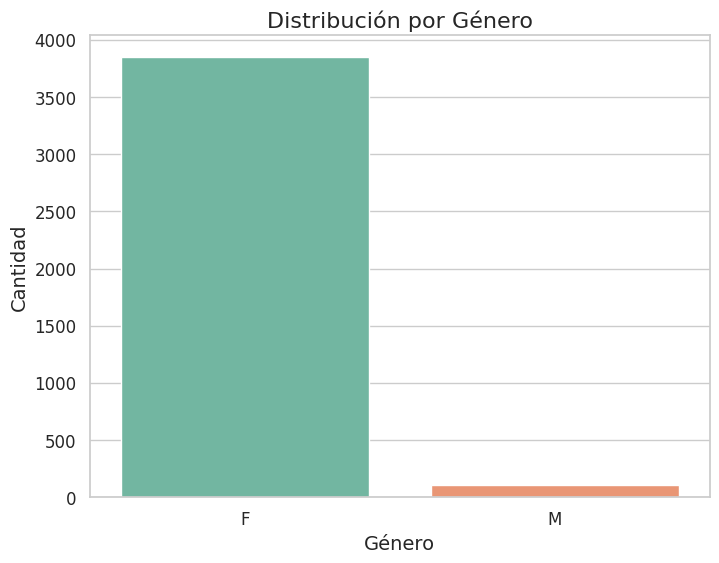

In [17]:
sns.set(style="whitegrid")

# Graficar por la variable género
plt.figure(figsize=(8, 6))
sns.countplot(x='GENERO', data=df, palette="Set2")
plt.title('Distribución por Género', fontsize=16)
plt.xlabel('Género', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<ipython-input-18-fef8eadd1c72>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ESTADO_CIVIL', data=df, palette="Set2")


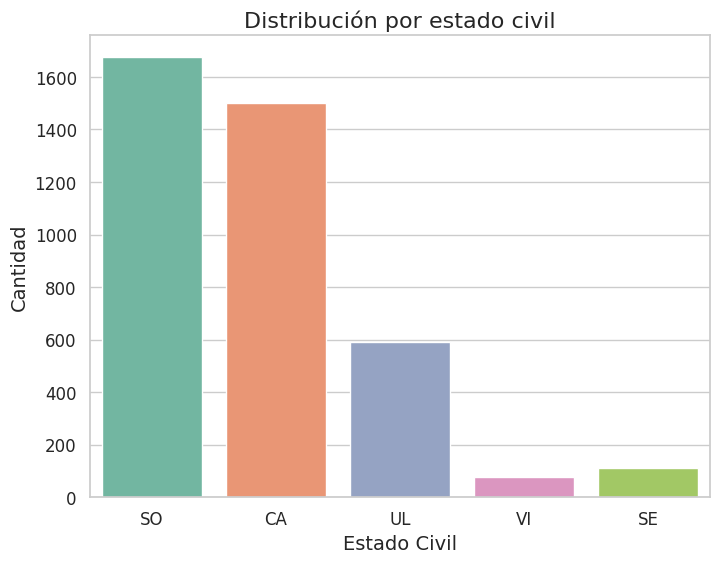

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='ESTADO_CIVIL', data=df, palette="Set2")
plt.title('Distribución por estado civil', fontsize=16)
plt.xlabel('Estado Civil', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

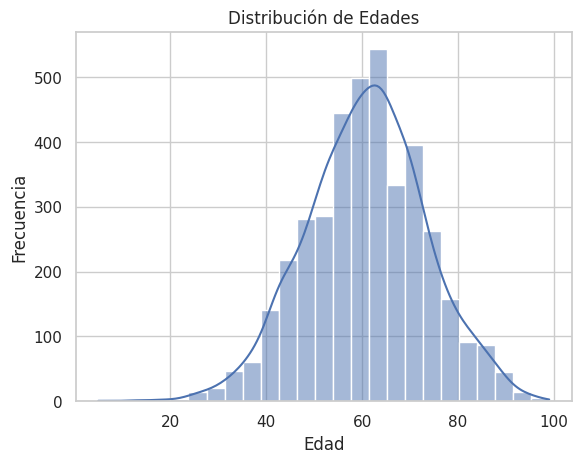

In [19]:
# Graficar la distribución de edades
sns.histplot(data=df, x='Edad', bins=25, kde=True)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edades')
plt.show()

<ipython-input-20-fed3476fb5cd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RIESGOS', data=df, palette="Set2")


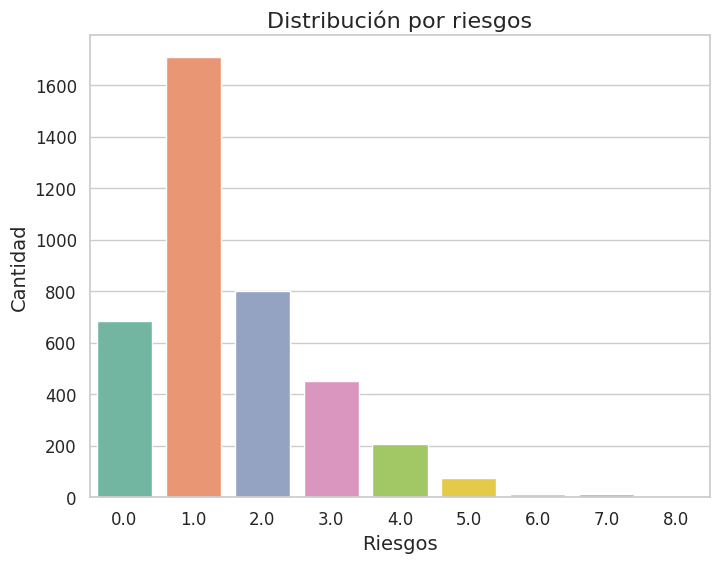

In [20]:
# Graficar la distribución de riesgos
plt.figure(figsize=(8, 6))
sns.countplot(x='RIESGOS', data=df, palette="Set2")
plt.title('Distribución por riesgos', fontsize=16)
plt.xlabel('Riesgos', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


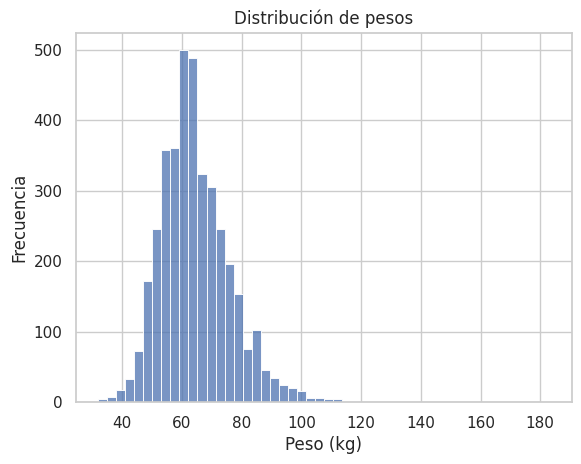

In [21]:
# Graficar la variable PESO
sns.histplot(df['PESO'], kde=False, bins=50)
plt.title('Distribución de pesos')
plt.xlabel('Peso (kg)')
plt.ylabel('Frecuencia')
plt.show()

In [22]:
#for column in df_num.columns: #df_num.columns: #df_cat.columns:
 # sns.histplot(df[column])
  #plt.show()
  #sns.boxplot(x=df[column])
  #plt.show()

**Nota:** Se observan múltiples variables con outliers, no obstante por efecto del ejercicio, se decide tomar estos outliers como no aleatorios. Por lo cuál, se mantendrá la información contenida en ellos.


##### **1.1.2.2. Balanceo de clases y Análisis variables categoricas**

In [23]:
df_cat = df.select_dtypes('object')
df_cat.columns

Index(['GENERO', 'ESTADO_CIVIL', 'MULTI_CANCER', 'atencion_nutricion'], dtype='object')

Distribución Train vs Test: Genero


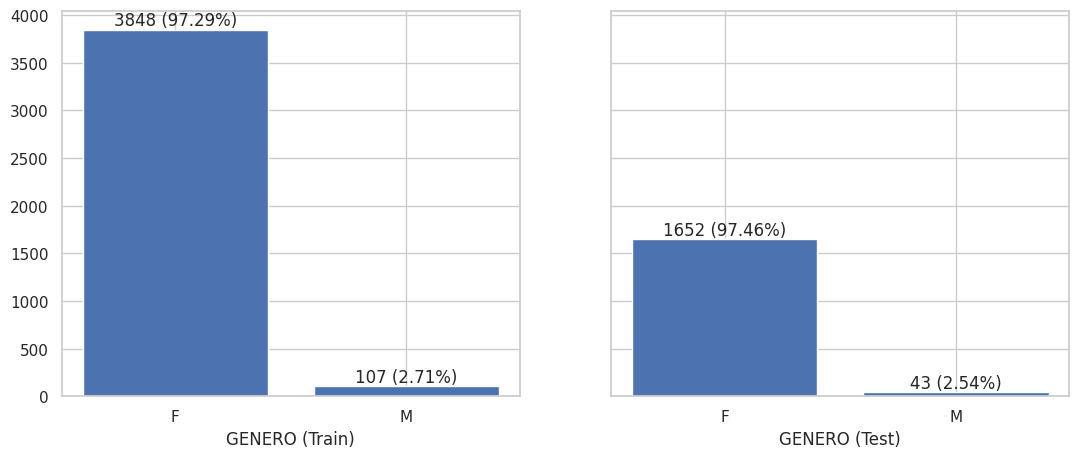

Distribución Train vs Test: Estado_civil


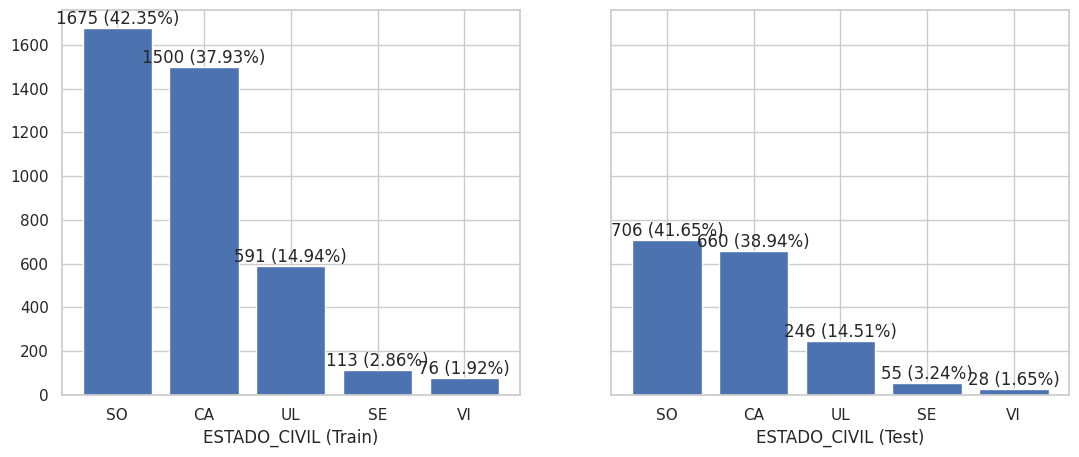

Distribución Train vs Test: Multi_cancer


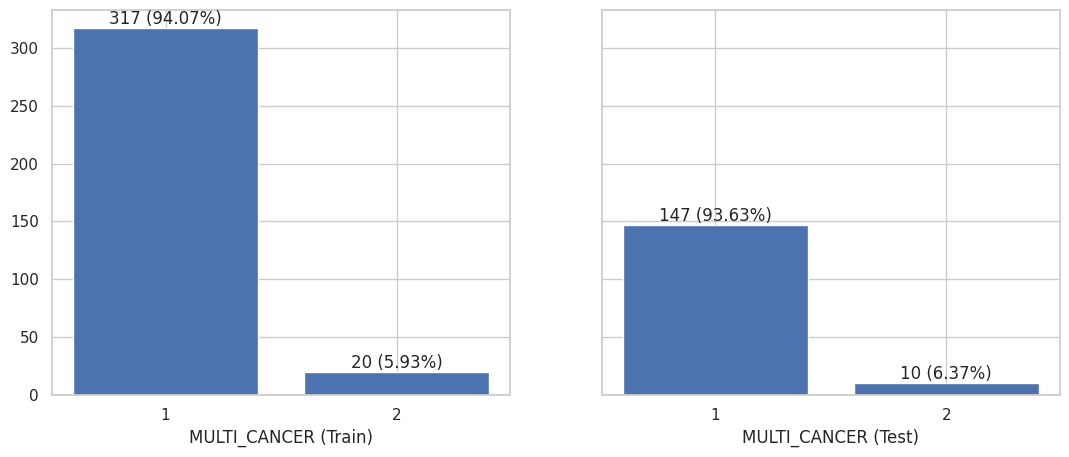

Distribución Train vs Test: Atencion_nutricion


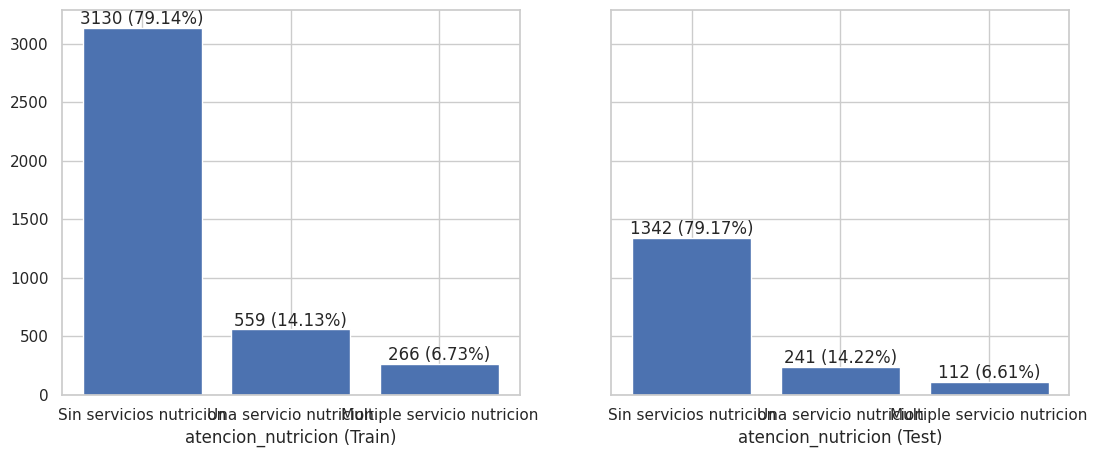

In [24]:
for column in df_cat.columns: #df_cat.columns:
  print('Distribución Train vs Test: '+str.capitalize(column))
  fig, axs = plt.subplots(1,2,figsize = (13,5), sharey= True)

  counts = df[column].value_counts()

  axs[0].bar(counts.index, counts.values)

  for i, value in enumerate(counts.values):
    percentage = f'{value / counts.sum() * 100:.2f}%'
    axs[0].text(i, value, f'{value} ({percentage})', ha='center', va='bottom')

  axs[0].set_xlabel(column+" (Train)")

  counts = df_test[column].value_counts()

  axs[1].bar(counts.index, counts.values)

  for i, value in enumerate(counts.values):
    percentage = f'{value / counts.sum() * 100:.2f}%'
    axs[1].text(i, value, f'{value} ({percentage})', ha='center', va='bottom')

  axs[1].set_xlabel(column+" (Test)")

  plt.show()


##### **1.1.2.3. Análisis variables binarias**

In [25]:
df_bin_columns = ((df.nunique()[df.nunique() == 2]).drop("Target")).index
df_bin_columns

Index(['GENERO', 'MULTI_CANCER', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object')

Distribución Train vs Test: Genero


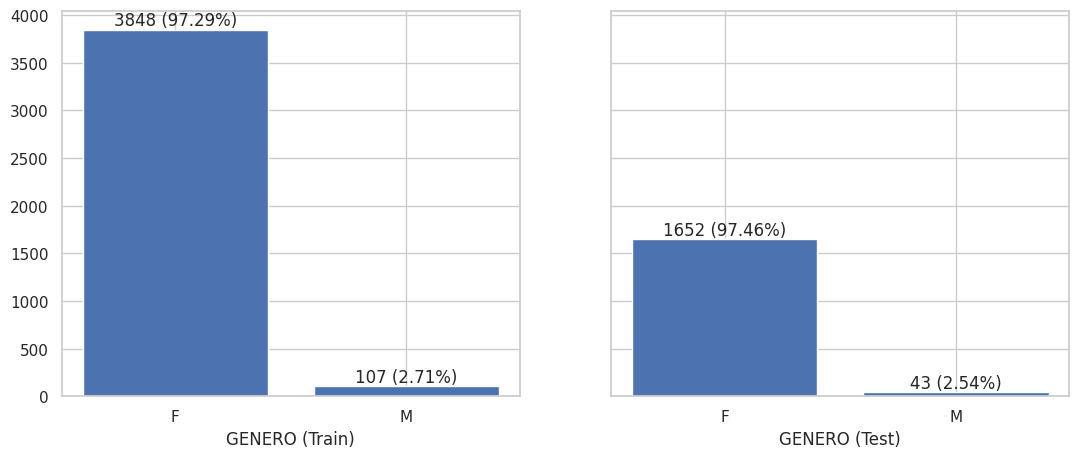

Distribución Train vs Test: Multi_cancer


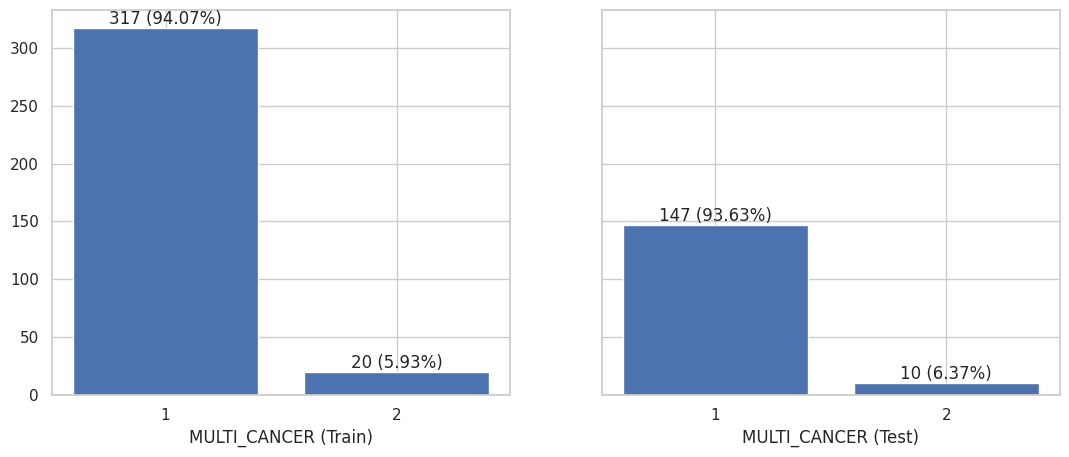

Distribución Train vs Test: Cesion


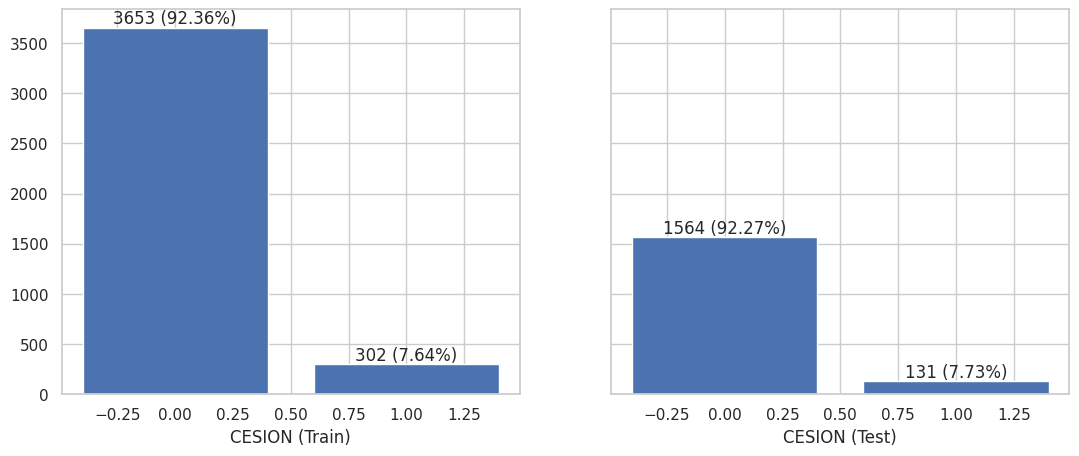

Distribución Train vs Test: Cancer_mama_familiar


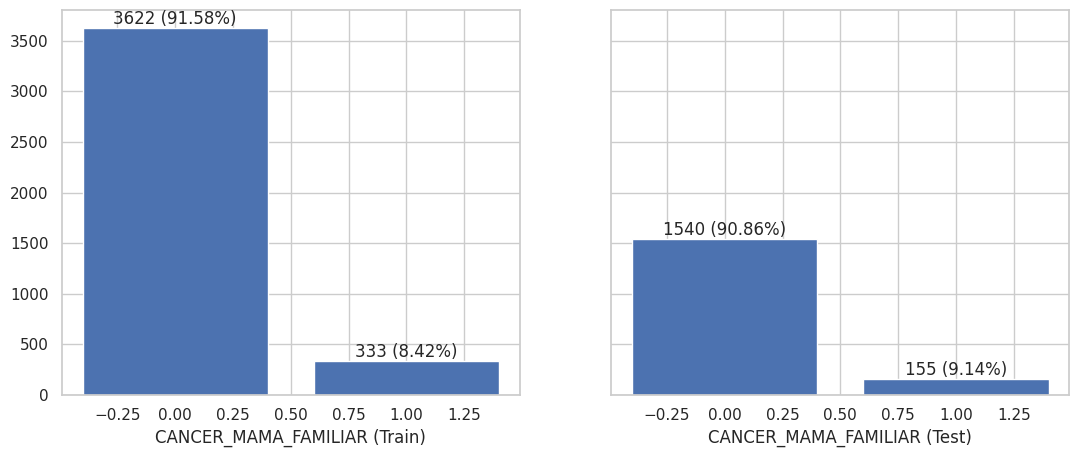

Distribución Train vs Test: Cancer_otro_sitio


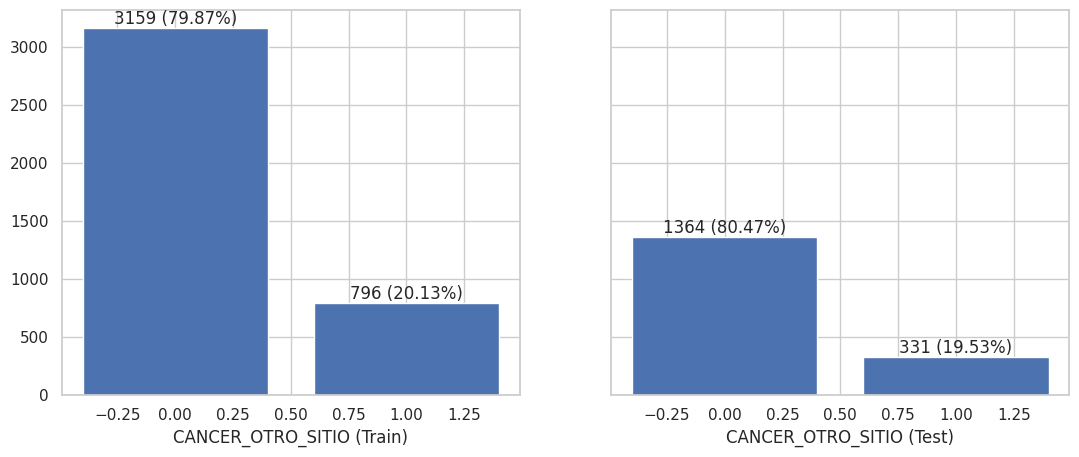

Distribución Train vs Test: Cancer_otro_sitio_familiar


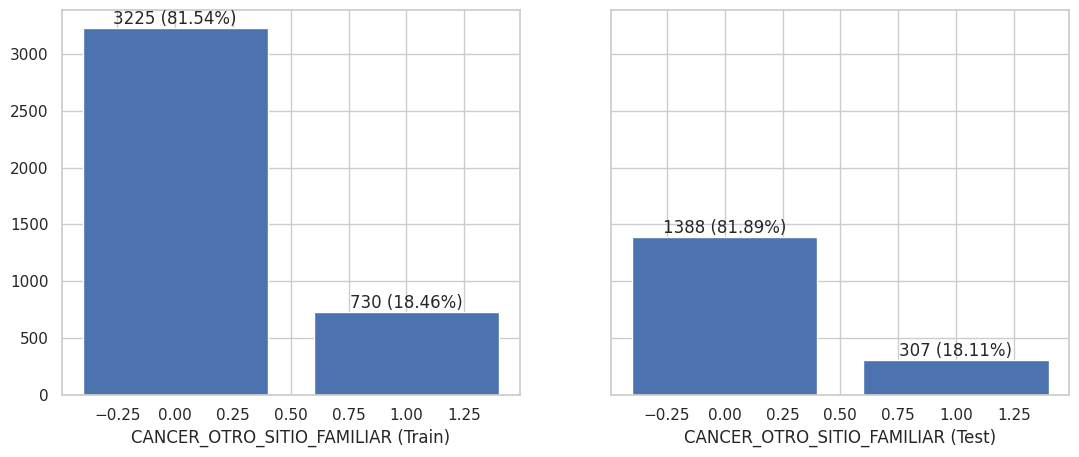

Distribución Train vs Test: Cerebral_familiar


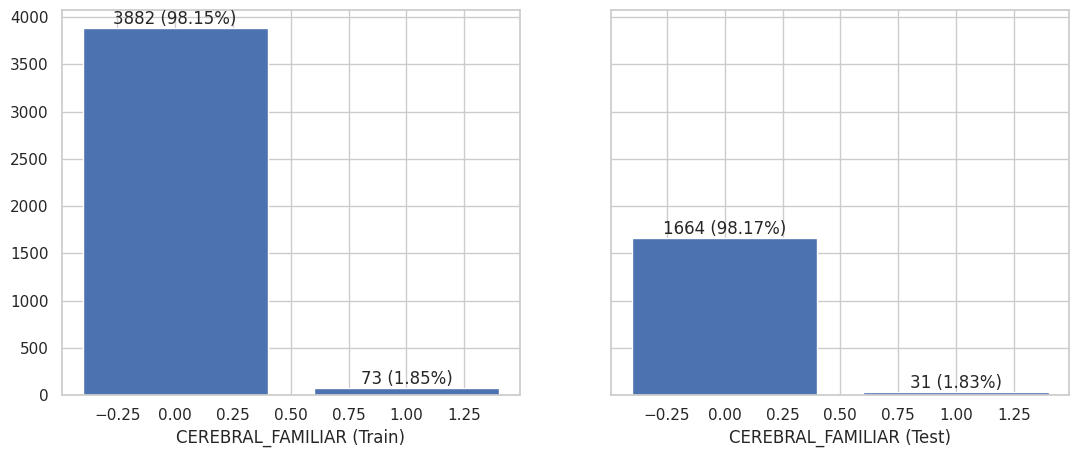

In [26]:
for column in df_bin_columns: #df_cat.columns:
  print('Distribución Train vs Test: '+str.capitalize(column))

  fig, axs = plt.subplots(1,2,figsize = (13,5), sharey= True)

  counts = df[column].value_counts()

  axs[0].bar(counts.index, counts.values)

  for i, value in enumerate(counts.values):
    percentage = f'{value / counts.sum() * 100:.2f}%'
    axs[0].text(i, value, f'{value} ({percentage})', ha='center', va='bottom')

  axs[0].set_xlabel(column+" (Train)")

  counts = df_test[column].value_counts()

  axs[1].bar(counts.index, counts.values)

  for i, value in enumerate(counts.values):
    percentage = f'{value / counts.sum() * 100:.2f}%'
    axs[1].text(i, value, f'{value} ({percentage})', ha='center', va='bottom')

  axs[1].set_xlabel(column+" (Test)")

  plt.show()

### **1.2. Análisis de valores faltantes**

In [27]:
# Muestra las variables con datos faltantes
print(df.isna().sum()[df.isna().sum() > 0])

MULTI_CANCER    3618
PESO             133
TALLA            133
TSISTOLICA       140
TDIASTOLICA      140
dtype: int64


In [28]:
faltantes=df.isna().sum()[df.isna().sum() > 0]
# Calcular el porcentaje de datos faltantes para cada variable
porcentaje_faltantes = (faltantes/len(df)) *100

# Mostrar el porcentaje de datos faltantes
print(porcentaje_faltantes)

MULTI_CANCER    91.479140
PESO             3.362832
TALLA            3.362832
TSISTOLICA       3.539823
TDIASTOLICA      3.539823
dtype: float64


Encontramos cinco variables con datos faltantes (MULTI_CANCER, PESO, TALLA, TSISTOLICA, TDIASTOLICA), La primera Variable MULTI_CANCER se imputa con el valor de cero (0) ya que representa si existen más tipos de cancer y al ser NA se toma como no presenta otro tipo de cancer.

In [29]:
# Imputamos la variable MULTI_CANCER con el valor de cero
df['MULTI_CANCER'] = df['MULTI_CANCER'].fillna(0)

<Axes: title={'center': 'Porcentaje de valores faltantes por variable'}, ylabel='Ratio de valores faltantes'>

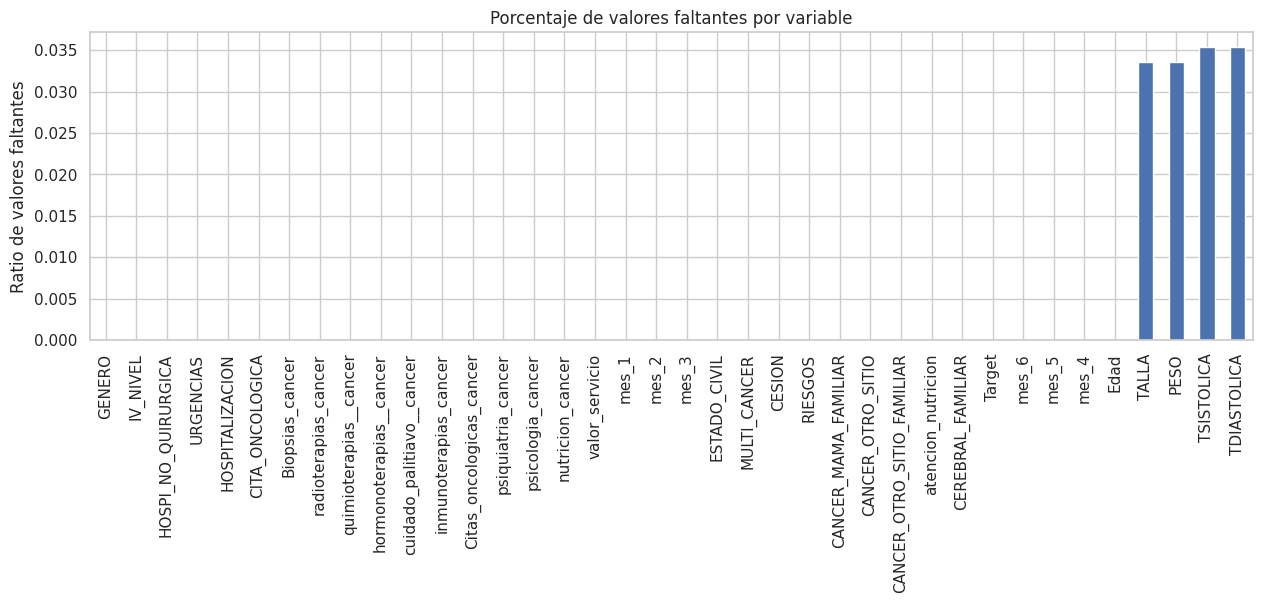

In [30]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Porcentaje de valores faltantes por variable",
    ylabel="Ratio de valores faltantes")

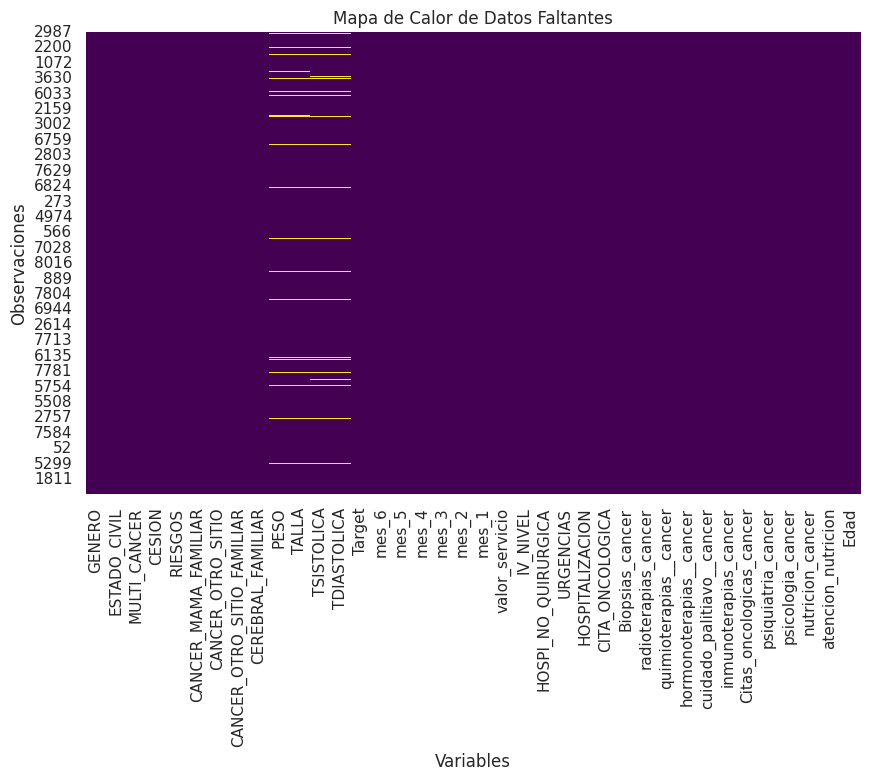

In [31]:
# Crear un DataFrame booleano indicando los valores faltantes
missing_data = df.isnull()

# Crear un mapa de calor de los datos faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes')
plt.xlabel('Variables')
plt.ylabel('Observaciones')
plt.show()

### **1.3. Imputación de valores**

In [32]:
def impute_missing_values(df, method='mean', params=None):

    if method == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif method == 'median':
        imputer = SimpleImputer(strategy='median')
    elif method == 'most_frequent':
        imputer = SimpleImputer(strategy='most_frequent')
    elif method == 'iterative':
        imputer = IterativeImputer(**params)
    elif method == 'knn':
        imputer = KNNImputer(**params)
    else:
        raise ValueError("Método de imputación no válido. Por favor, elija entre 'mean', 'median', 'most_frequent', 'iterative' o 'knn'.")

    # Identificar columnas numéricas
    columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

    # Copiar DataFrame
    df_imputed = df.copy()

    # Imputación
    if method != 'knn':
        df_imputed[columnas_numericas] = imputer.fit_transform(df_imputed[columnas_numericas])
    else:
        imputer.fit(df_imputed[columnas_numericas])
        df_imputed[columnas_numericas] = imputer.transform(df_imputed[columnas_numericas])

    return df_imputed

In [33]:
params_knn = {'n_neighbors': 5}
df = impute_missing_values(df, method='knn', params=params_knn)

In [34]:
df.isna().sum()

GENERO                        0
ESTADO_CIVIL                  0
MULTI_CANCER                  0
CESION                        0
RIESGOS                       0
CANCER_MAMA_FAMILIAR          0
CANCER_OTRO_SITIO             0
CANCER_OTRO_SITIO_FAMILIAR    0
CEREBRAL_FAMILIAR             0
PESO                          0
TALLA                         0
TSISTOLICA                    0
TDIASTOLICA                   0
Target                        0
mes_6                         0
mes_5                         0
mes_4                         0
mes_3                         0
mes_2                         0
mes_1                         0
valor_servicio                0
IV_NIVEL                      0
HOSPI_NO_QUIRURGICA           0
URGENCIAS                     0
HOSPITALIZACION               0
CITA_ONCOLOGICA               0
Biopsias_cancer               0
radioterapias_cancer          0
quimioterapias__cancer        0
hormonoterapias__cancer       0
cuidado_palitiavo__cancer     0
inmunote

### **1.4. Análisis de Baseline**

In [332]:
df['Target'].value_counts(True) * 100

Target
0.0    88.697851
1.0    11.302149
Name: proportion, dtype: float64

## **2. Feature Engineering**

### **2.1. Tratamiento de variables categoricas**



In [36]:
# Selecciona solo las características categóricas para el tratamiento
columnas_categoricas = df.select_dtypes(include=['object']).columns
df_categoricas = df[columnas_categoricas]

# Codificación one-hot
df_encoded = pd.get_dummies(df_categoricas)

# Concatena las variables categóricas codificadas con el DataFrame original
df_final = pd.concat([df, df_encoded], axis=1)

# Elimina las columnas originales de las variables categóricas
df_final.drop(columns=columnas_categoricas, inplace=True)

# Visualiza el DataFrame resultante con las variables categóricas codificadas
df_final.head()

,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,CEREBRAL_FAMILIAR,PESO,TALLA,TSISTOLICA,TDIASTOLICA,...,ESTADO_CIVIL_SE,ESTADO_CIVIL_SO,ESTADO_CIVIL_UL,ESTADO_CIVIL_VI,MULTI_CANCER_0,MULTI_CANCER_1,MULTI_CANCER_2,atencion_nutricion_Multiple servicio nutricion,atencion_nutricion_Sin servicios nutricion,atencion_nutricion_Una servicio nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,0.0,2.0,0.0,0.0,1.0,0.0,52.0,149.0,112.0,70.0,...,False,True,False,False,True,False,False,False,True,False
3423,0.0,1.0,0.0,0.0,0.0,0.0,67.0,163.0,120.0,80.0,...,False,False,False,False,True,False,False,False,True,False
6981,0.0,3.0,0.0,0.0,0.0,0.0,77.0,152.0,110.0,80.0,...,False,True,False,False,True,False,False,False,False,True
6701,0.0,1.0,0.0,0.0,0.0,0.0,60.0,160.0,120.0,80.0,...,False,True,False,False,True,False,False,False,True,False
7361,0.0,1.0,0.0,0.0,0.0,0.0,56.5,157.0,117.0,65.0,...,False,False,True,False,True,False,False,False,True,False


### **2.2. PCA**

In [37]:
# Distribución de varianza
pd.DataFrame(np.var(df_final))

,0
CESION,7.052834e-02
RIESGOS,1.538262e+00
CANCER_MAMA_FAMILIAR,7.710805e-02
CANCER_OTRO_SITIO,1.607569e-01
CANCER_OTRO_SITIO_FAMILIAR,1.505080e-01
CEREBRAL_FAMILIAR,1.811696e-02
PESO,1.322894e+02
TALLA,4.459073e+01
TSISTOLICA,1.404627e+02
TDIASTOLICA,6.317427e+01


**Nota:** Los variables mes_1,mes_2,mes_3,mes_4,mes_5,mes_6 son responsables de la mayoría de la varianza. Son las variables que aportarían mayor información en caso de no normalizarse los datos. No obstante, PCA debe aplicarse a variables estandarizadas.

In [38]:
# Estandarización de variables
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(df_final)
print(scaler.mean_)

[7.63590392e-02 1.52718078e+00 8.41972187e-02 2.01264223e-01
 1.84576485e-01 1.84576485e-02 6.47497649e+01 1.56320303e+02
 1.19900076e+02 7.41033123e+01 1.13021492e-01 6.99814635e+05
 8.05840947e+05 9.35292603e+05 8.44727080e+05 8.57028126e+05
 1.16366138e+06 5.30636477e+06 5.57345133e+00 3.48925411e-02
 1.16308470e-02 2.57901391e-02 2.21769912e+00 1.39494311e+00
 8.06573957e-02 4.70290771e-02 4.57142857e-01 1.56257901e-01
 7.33249052e-03 2.33678887e+00 1.05436157e-01 2.10872314e-01
 3.62073325e-01 6.07959545e+01 9.72945638e-01 2.70543616e-02
 3.79266751e-01 2.85714286e-02 4.23514539e-01 1.49431100e-01
 1.92161820e-02 9.14791403e-01 8.01517067e-02 5.05689001e-03
 6.72566372e-02 7.91403287e-01 1.41340076e-01]


In [39]:
df_std = scaler.transform(df_final)

In [40]:
pca = PCA()
df_proyectado = pca.fit_transform(df_std)

In [41]:
pca.explained_variance_ratio_

array([1.13285691e-01, 6.10791574e-02, 5.91216762e-02, 4.62182872e-02,
       3.94754971e-02, 3.65385160e-02, 3.59298014e-02, 3.40735515e-02,
       3.36800508e-02, 3.07150445e-02, 2.89522561e-02, 2.70005560e-02,
       2.60006939e-02, 2.55525604e-02, 2.44037541e-02, 2.32183797e-02,
       2.23638899e-02, 2.20642994e-02, 2.13505784e-02, 2.11322926e-02,
       2.08431556e-02, 2.02550362e-02, 1.97025803e-02, 1.89902338e-02,
       1.85840661e-02, 1.83743640e-02, 1.78918599e-02, 1.62693794e-02,
       1.41898794e-02, 1.41248583e-02, 1.22070224e-02, 1.15013722e-02,
       1.06102275e-02, 1.02458632e-02, 9.11069390e-03, 8.14499951e-03,
       6.89529954e-03, 6.13456898e-03, 5.61170296e-03, 4.92095459e-03,
       2.82237627e-03, 4.12972284e-04, 3.10535024e-32, 8.84492941e-33,
       4.29213491e-33, 1.07307909e-33, 5.04206090e-34])

In [42]:
len(df_final.columns)

47

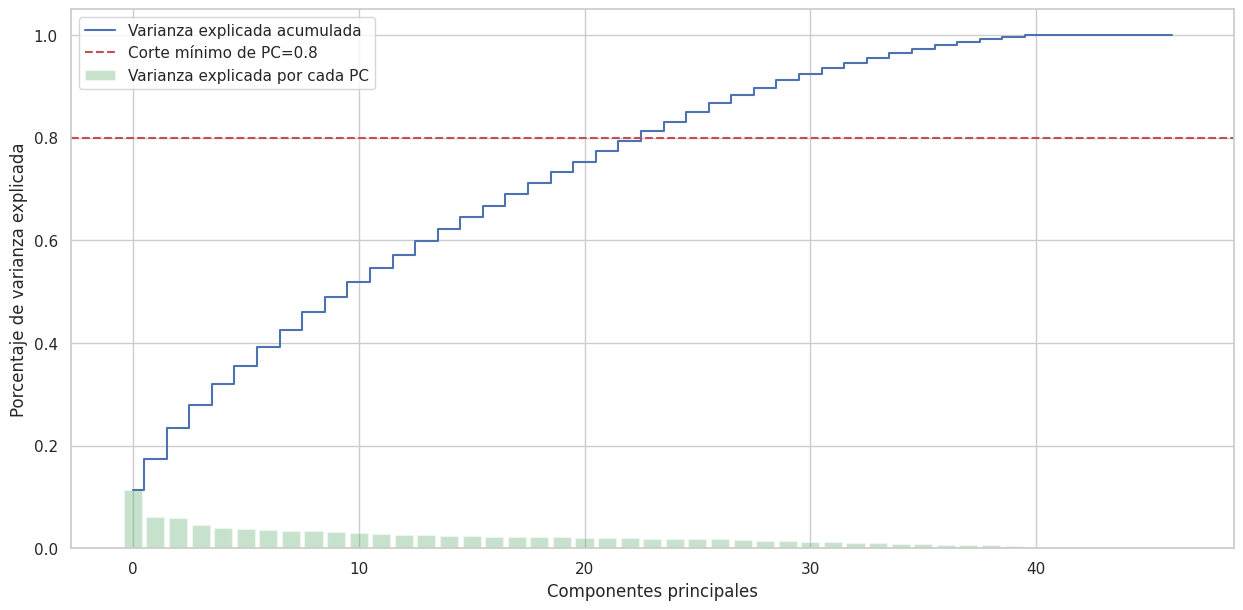

In [43]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

paso = 1
linea_horizontal_y = 0.8

plt.figure(figsize=(15, 7))
plt.bar(np.arange(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color='g')
plt.step(np.arange(len(cum_var_exp)), cum_var_exp, where='mid', label='Varianza explicada acumulada')
plt.axhline(y=linea_horizontal_y, color='r', linestyle='--', label=f'Corte mínimo de PC={linea_horizontal_y}')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')

plt.legend(loc='best')
plt.show()

### **2.3. Selección de variables**

In [44]:
np.sum(pca.explained_variance_ratio_[0:30])

0.9113819467060589

In [45]:
np.sum(pca.explained_variance_ratio_[0:23])

0.7929573057600031

**Nota:** Con los primeros 30 componentes principales, contiene el 91.1% de la información. Con 20 componentes principales se contiene el 79.3% de la información.

## **3. Calibración y Selección del modelo**

In [124]:
from imblearn.under_sampling import RandomUnderSampler

In [209]:
df = pd.read_parquet("/content/df_train.parquet")
X, y = df.drop(columns="Target"), df["Target"]
X = preprocesamiento_inicial(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
var_numericas = ['CESION', 'RIESGOS', 'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR', 'PESO', 'TALLA',
       'TSISTOLICA', 'TDIASTOLICA', 'mes_6', 'mes_5', 'mes_4', 'mes_3',
       'mes_2', 'mes_1', 'valor_servicio', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'URGENCIAS', 'HOSPITALIZACION', 'CITA_ONCOLOGICA', 'Biopsias_cancer',
       'radioterapias_cancer', 'quimioterapias__cancer',
       'hormonoterapias__cancer', 'cuidado_palitiavo__cancer',
       'inmunoterapias_cancer', 'Citas_oncologicas_cancer',
       'psiquiatria_cancer', 'psicologia_cancer', 'nutricion_cancer', 'Edad']
var_categoricas= ['GENERO','ESTADO_CIVIL','atencion_nutricion']

### **3.1. Custom Transformers**

In [164]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y)
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

### **3.2. Pipelines de preprocesamiento**

In [216]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

column_transformer = ColumnTransformer(
    transformers=[("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas)
    ]
)

preprocessor = Pipeline([("Transformers", column_transformer), ("PCA", PCA(n_components=30))])

In [217]:
preprocessor.fit(X)

Pipeline(steps=[('Transformers',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CESION', 'RIESGOS',
                                                   'CANCER_MAMA_FAMILIAR',
                                                   'CANCER_OTRO_SITIO',
                                                   'CANCER_OTRO_SITIO_FAMILIAR',
                                                   'CEREBRAL_FAMILIAR', 'PESO',
                                                   'TALLA', 'TSISTOLICA',
                                                   'TDIASTOLICA', 'mes_6',
                                                   'mes_5', 'mes_4', 'mes_3',
                                                   'm...
                                                   'CITA_ONCOLOGICA',
                                                   'Biopsias_cancer',
                                                   'radioterapias_cancer',
                                                   'quimioterapias__cancer',
                                                   'hormonoterapias__cancer',
                                                   'cuidado_palitiavo__cancer',
                                                   'inmunoterapias_cancer',
                                                   'Citas_oncologicas_cancer',
                                                   'psiquiatria_cancer', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['GENERO', 'ESTADO_CIVIL',
                                                   'atencion_nutricion'])])),
                ('PCA', PCA(n_components=30))])

### **3.3. Modelos**

In [235]:
# Carga de información
df = pd.read_parquet("/content/df_train.parquet")
X, y = df.drop(columns="Target"), df["Target"]
X = preprocesamiento_inicial(X)
X = preprocessor.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state=42)
var_numericas = ['CESION', 'RIESGOS', 'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR', 'PESO', 'TALLA',
       'TSISTOLICA', 'TDIASTOLICA', 'mes_6', 'mes_5', 'mes_4', 'mes_3',
       'mes_2', 'mes_1', 'valor_servicio', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'URGENCIAS', 'HOSPITALIZACION', 'CITA_ONCOLOGICA', 'Biopsias_cancer',
       'radioterapias_cancer', 'quimioterapias__cancer',
       'hormonoterapias__cancer', 'cuidado_palitiavo__cancer',
       'inmunoterapias_cancer', 'Citas_oncologicas_cancer',
       'psiquiatria_cancer', 'psicologia_cancer', 'nutricion_cancer', 'Edad']
var_categoricas= ['GENERO','ESTADO_CIVIL','atencion_nutricion']

#### **3.3.1. Regresión Logistica**

In [236]:
log = LogisticRegression(max_iter=1200,solver="lbfgs")
log.fit(X_train, Y_train)
pred_lr = log.predict(X_test)
acc_lr = accuracy_score(Y_test, pred_lr)
print(f"Accuracy of Logistic Regression Model: {round(acc_lr*100, 2)}%")

Accuracy of Logistic Regression Model: 92.26%


In [237]:
metrics = pd.DataFrame({"RL": {"Accuracy": accuracy_score(Y_test, pred_lr), "Recall":recall_score(Y_test,pred_lr), "F1_Score": f1_score(Y_test,pred_lr)}})


#### **3.3.1. Árbol de decisión**

In [238]:
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, Y_train)
pred_dtree = d_tree.predict(X_test)
acc_dtree = accuracy_score(Y_test, pred_dtree)
print(f"Accuracy of Decision Tree Model: {round(acc_lr*100, 2)}%")

Accuracy of Decision Tree Model: 92.26%


In [239]:
metrics["DTree"] = {"Accuracy": accuracy_score(Y_test, pred_dtree), "Recall":recall_score(Y_test,pred_dtree), "F1_Score": f1_score(Y_test,pred_dtree)}

#### **3.3.2. KNN**

In [230]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, Y_train)
pred_knn = KNN.predict(X_test)
acc_knn = accuracy_score(Y_test, pred_knn)
print(f"Accuracy of KNN Model: {round(acc_knn*100, 2)}%")

Accuracy of KNN Model: 91.75%


In [240]:
metrics["KNN"] = {"Accuracy": accuracy_score(Y_test, pred_knn), "Recall":recall_score(Y_test,pred_knn), "F1_Score": f1_score(Y_test,pred_knn)}

#### **3.3.3. SVC**

In [241]:
svc = SVC()
svc.fit(X_train, Y_train)
pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(Y_test, pred_svc)
print(f"Accuracy of SVC Model: {round(acc_knn*100, 2)}%")

Accuracy of SVC Model: 91.75%


In [242]:
metrics["SVC"] = {"Accuracy": accuracy_score(Y_test, pred_svc), "Recall":recall_score(Y_test,pred_svc), "F1_Score": f1_score(Y_test,pred_svc)}

#### **3.3.4. XGB**

In [243]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train,Y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

acc_svc_xgb = accuracy_score(Y_test, y_pred_xgb)
print(f"Accuracy after Boosting: {acc_svc_xgb*100}%")

Accuracy after Boosting: 89.73063973063972%


In [244]:
f1_score(Y_test,y_pred_xgb)

0.4077669902912622

In [245]:
metrics["XGB"] = {"Accuracy": accuracy_score(Y_test, y_pred_xgb), "Recall":recall_score(Y_test,y_pred_xgb), "F1_Score": f1_score(Y_test,y_pred_xgb)}


#### **3.3.5. Naive Bayes**

In [247]:
# Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, Y_train)

# Realizar predicciones
Y_pred_NB = model_nb.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test, Y_pred_NB)


In [248]:
metrics["NaiveBayes"] = {"Accuracy": accuracy_score(Y_test, Y_pred_NB), "Recall":recall_score(Y_test,Y_pred_NB), "F1_Score": f1_score(Y_test,Y_pred_NB)}

#### **3.3.6. Red Neuronal Profunda**

In [196]:
# Función para crear el modelo con los mejores hiperparámetros
def create_best_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(num_features,), kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo con los mejores hiperparámetros
best_model = create_best_model()

# Entrenar el modelo
history = best_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluar el modelo en los datos de prueba
loss, accuracy = best_model.evaluate(X_test, Y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/30
84/84 [==============================] - 2s 10ms/step - loss: 0.5474 - accuracy: 0.9044 - val_loss: 0.3228 - val_accuracy: 0.9019
Epoch 2/30
84/84 [==============================] - 0s 3ms/step - loss: 0.3098 - accuracy: 0.9141 - val_loss: 0.3185 - val_accuracy: 0.9019
Epoch 3/30
84/84 [==============================] - 0s 3ms/step - loss: 0.3075 - accuracy: 0.9118 - val_loss: 0.3252 - val_accuracy: 0.8915
Epoch 4/30
84/84 [==============================] - 0s 3ms/step - loss: 0.3073 - accuracy: 0.9077 - val_loss: 0.3178 - val_accuracy: 0.8945
Epoch 5/30
84/84 [==============================] - 0s 3ms/step - loss: 0.2985 - accuracy: 0.9148 - val_loss: 0.3080 - val_accuracy: 0.9034
Epoch 6/30
84/84 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.9148 - val_loss: 0.3150 - val_accuracy: 0.8975
Epoch 7/30
84/84 [==============================] - 0s 3ms/step - loss: 0.2887 - accuracy: 0.9111 - val_loss: 0.3080 - val_accuracy: 0.8975
Epoch 8/30
84/84 [=

In [249]:
pred_RN = best_model.predict(X_test)
threshold = 0.5
pred_RN = np.where(predictions > threshold, 1, 0)

InvalidArgumentError: Graph execution error:

Detected at node sequential_228/dense_684/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-249-61bb66230869>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2350, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2137, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2123, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2111, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2079, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 561, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1132, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/sequential.py", line 413, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 511, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 668, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1132, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/activations.py", line 317, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/backend.py", line 5369, in relu

Matrix size-incompatible: In[0]: [32,30], In[1]: [42,128]
	 [[{{node sequential_228/dense_684/Relu}}]] [Op:__inference_predict_function_2370372]

In [250]:
metrics["RedNeuronal"] = {"Accuracy": accuracy_score(Y_test, pred_RN), "Recall":recall_score(Y_test,pred_RN), "F1_Score": f1_score(Y_test,pred_RN)}

#### **3.3.7. Resumen de métricas**

In [251]:
metrics

,RL,DTree,KNN,SVC,XGB,NaiveBayes,RedNeuronal
Accuracy,0.922559,0.843434,0.917508,0.914141,0.897306,0.887205,0.919192
F1_Score,0.520833,0.358621,0.484211,0.400000,0.407767,0.488550,0.466667
Recall,0.373134,0.388060,0.343284,0.253731,0.313433,0.477612,0.313433


In [197]:
best_model.save("best_model.h5")
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("best_model.h5")

### **3.4. Optimización Bayesiana**

In [253]:
df = pd.read_parquet("/content/df_train.parquet")
X, y = df.drop(columns="Target"), df["Target"]
X = preprocesamiento_inicial(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
var_numericas = ['CESION', 'RIESGOS', 'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR', 'PESO', 'TALLA',
       'TSISTOLICA', 'TDIASTOLICA', 'mes_6', 'mes_5', 'mes_4', 'mes_3',
       'mes_2', 'mes_1', 'valor_servicio', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'URGENCIAS', 'HOSPITALIZACION', 'CITA_ONCOLOGICA', 'Biopsias_cancer',
       'radioterapias_cancer', 'quimioterapias__cancer',
       'hormonoterapias__cancer', 'cuidado_palitiavo__cancer',
       'inmunoterapias_cancer', 'Citas_oncologicas_cancer',
       'psiquiatria_cancer', 'psicologia_cancer', 'nutricion_cancer', 'Edad']
var_categoricas= ['GENERO','ESTADO_CIVIL','atencion_nutricion']

#### **3.4.1. Support Vector Machine**

In [254]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:]
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [267]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,
    n_components,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC


) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)

    numeric_transformer = Pipeline(
        steps=[("imputer", imputer),
               ("scaler", scaler_cls()),
               ("LDA_feature",LDATransformer())
              ]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )

    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),("PCA",PCA(n_components=int(n_components))),

    ])

    #Model SVM
    kernel_SVC = int(kernel_SVC)
    if kernel_SVC == 1:
      kernel_SVC_name = 'linear'
    elif kernel_SVC == 2:
      kernel_SVC_name = 'poly'
    elif kernel_SVC == 3:
      kernel_SVC_name = 'rbf'
    elif kernel_SVC == 4:
      kernel_SVC_name = 'sigmoid'

    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel_SVC_name, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol

    kf = KFold(n_splits=3, random_state=963, shuffle=True)

    train_fold_metrics = [0.5,0.6,0.65]
    val_fold_metrics = [0.4, 0.45,0.47]

    # K-Fold cross val

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")

        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)

        val_preds = pipeline.predict_proba(kX_val)[:, 1]

        train_preds = pipeline.predict_proba(kX_train)[:, 1]

        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th

        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)

        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)

    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)

    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)

    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()

    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)

    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result

In [269]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    n_components=(20,40),
    SVC_C=(0.001, 10),
    SVC_gamma=(0,5),
    kernel_SVC=(1,4)

)

optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=123,
    verbose=2,
)

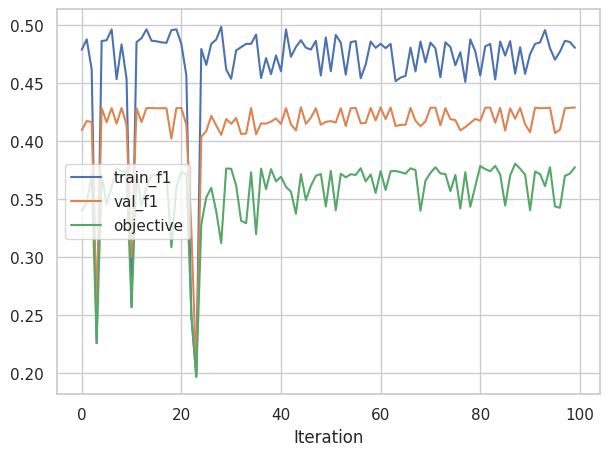

In [270]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=150,
)

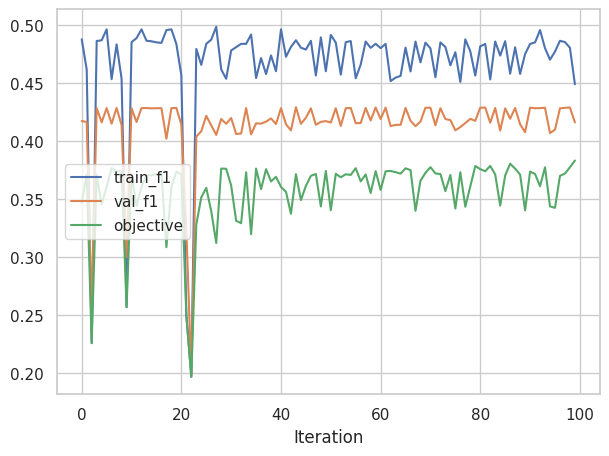

In [271]:
best_model_svc, best_result_svc = train_and_evaluate(**optimizer.max["params"])

In [273]:
test_preds = best_model_svc.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, test_preds)

0.8274411302982732

In [274]:
best_model_svc.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   ['CESION',
                                                                    'RIESGOS',
                                                                    'CANCER_MAMA_FAMILIAR',
                                                                    'CANCER_OTRO_SITIO',
                                                                    'CANCER_OTRO_SITIO_FAMILIAR',
                                                                    'CEREBRAL_FAMILIAR',
                                                                    'PESO',
                                                                    'TALLA',...
                                                                    'quimioterapias__cancer',
                                                                    'hormonoterapias__cancer',
                                                                    'cuidado_palitiavo__cancer',
                                                                    'inmunoterapias_cancer',
                                                                    'Citas_oncologicas_cancer',
                                                                    'psiquiatria_cancer', ...]),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['GENERO',
                                                                    'ESTADO_CIVIL',
                                                                    'atencion_nutricion'])])),
                                 ('PCA', PCA(n_components=34))])),
                ('model',
                 SVC(C=10.0, gamma=0.0, kernel='linear', probability=True))])

In [275]:
optimizer.max["params"]

{'SVC_C': 10.0,
 'SVC_gamma': 0.0,
 'imputer_strategy': 1.0,
 'kernel_SVC': 1.0,
 'knn_imputer': 1.0,
 'knn_imputer_k': 3.0,
 'n_components': 34.356729617640916,
 'scaler_choice': 1.0}

In [276]:
with open("best_model_svc.pkl", "wb") as f:
    pickle.dump(best_model_svc, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-04-08 01:00:10         2666
metadata.json                                  2024-04-08 01:00:10           64
variables.h5                                   2024-04-08 01:00:10       193256


In [278]:
test_preds = best_model_svc.predict_proba(X_test)[:, 1]
train_preds = best_model_svc.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.22322322322322322

In [279]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")

Train f1: 0.5047801147227534
Test f1: 0.6029411764705882


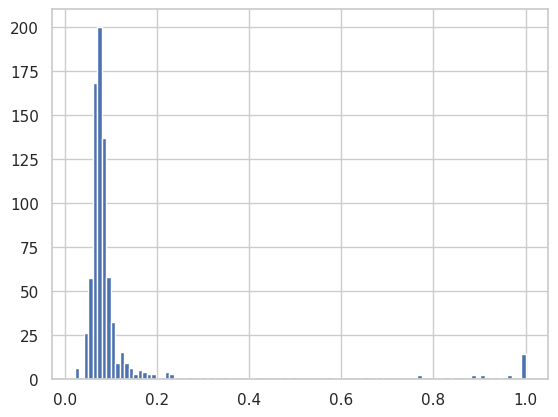

In [280]:
plt.hist(test_preds, bins=100)
plt.show()

#### **3.4.2. Red Neuronal Profunda**

In [281]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:]
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [284]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,
    n_components,
    # Model
    model_hidden_layer_size_exp,
    model_lr_init,
    model_alpha,
    model_batch_size,
    model_max_iter,
    model_solver,
    verbose=0,
    show_live_plot=True

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)

    numeric_transformer = Pipeline(
        steps=[("imputer", imputer),
               ("scaler", scaler_cls()),
               ("LDA_feature",LDATransformer())
              ]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )

    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),("PCA",PCA(n_components=int(n_components))),

    ])

    ## Model configuration

    max_exponent = int(model_hidden_layer_size_exp)
    if max_exponent<2:
        max_exponent=2

    model_kwargs = dict(
        hidden_layer_sizes = [2**(n) for n in reversed(range(2, max_exponent+1))], ### Arquitectura
        solver="adam" if model_solver > 0.5 else "sgd",
        batch_size=2**int(model_batch_size), ## Back Propagation
        learning_rate_init=model_lr_init,## Back Propagation
        alpha=model_alpha,## Back Propagation
        max_iter=int(model_max_iter),
        early_stopping=True,
        random_state=42,
    )

    if verbose:
        print("MLP Classifier params: ")
        print(model_kwargs)

    model = MLPClassifier(**model_kwargs)

    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol

    kf = KFold(n_splits=3, random_state=963, shuffle=True)

    train_fold_metrics = []
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)

        val_preds = pipeline.predict_proba(kX_val)[:, 1]

        train_preds = pipeline.predict_proba(kX_train)[:, 1]

        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th

        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)

        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)

    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)

    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)

    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()

    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)

    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result


In [285]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    n_components=(20,40),
    # Model
    model_solver=(0, 1),
    model_hidden_layer_size_exp=(2, 4),
    model_lr_init=(0.001, 1),
    model_alpha=(0.001, 10),
    model_batch_size=(3, 7), # from 2**6=64 to 2**12=4096
    model_max_iter=(50, 50)
)


In [286]:
data_plot = collections.defaultdict(list)

In [287]:
optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=123,
    verbose=2,
)

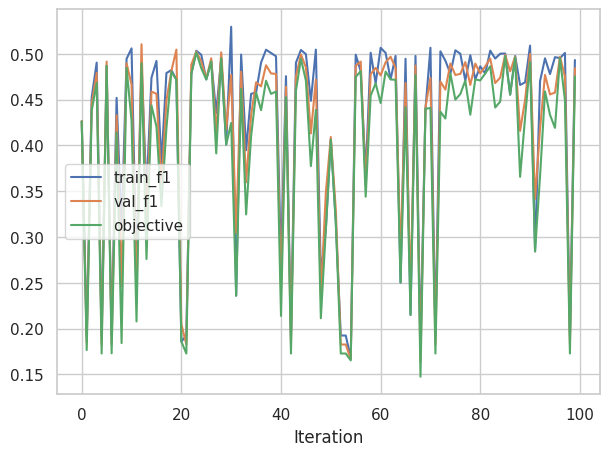

| 104       | 0.4754    | 1.0       | 0.2567    | 7.132     | 3.465     | 6.343     | 3.491     | 0.2495    | 50.0      | 0.0       | 32.61     | 0.9556    |


In [289]:
#logger = JSONLogger(path="./logs.json")
#optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

In [290]:
optimizer.max

{'target': 0.5015376951190073,
 'params': {'imputer_strategy': 0.0,
  'knn_imputer': 0.38317649288458056,
  'knn_imputer_k': 3.0,
  'model_alpha': 5.961323453565742,
  'model_batch_size': 6.800600228788291,
  'model_hidden_layer_size_exp': 2.313601952799177,
  'model_lr_init': 0.12695611308719415,
  'model_max_iter': 50.0,
  'model_solver': 0.0,
  'n_components': 33.50702800114864,
  'scaler_choice': 1.0}}

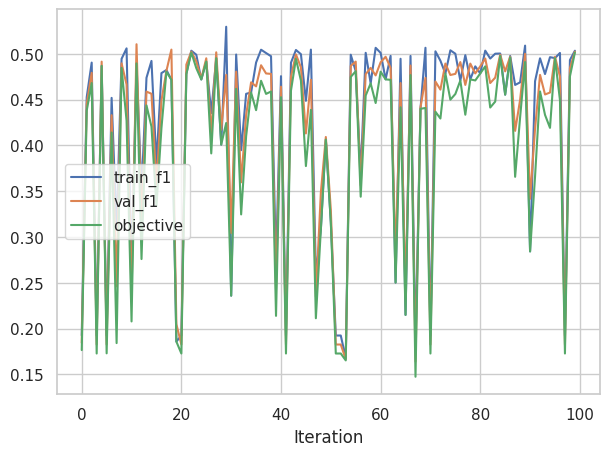

In [291]:
best_model_rn, best_result_rn = train_and_evaluate(**optimizer.max["params"], show_live_plot=False)

In [295]:
best_model_rn.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   ['CESION',
                                                                    'RIESGOS',
                                                                    'CANCER_MAMA_FAMILIAR',
                                                                    'CANCER_OTRO_SITIO',
                                                                    'CANCER_OTRO_SITIO_FAMILIAR',
                                                                    'CEREBRAL_FAMILIAR',
                                                                    'PESO',
                                                                    '...
                                                                    'Citas_oncologicas_cancer',
                                                                    'psiquiatria_cancer', ...]),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['GENERO',
                                                                    'ESTADO_CIVIL',
                                                                    'atencion_nutricion'])])),
                                 ('PCA', PCA(n_components=33))])),
                ('model',
                 MLPClassifier(alpha=5.961323453565742, batch_size=64,
                               early_stopping=True, hidden_layer_sizes=[4],
                               learning_rate_init=0.12695611308719415,
                               max_iter=50, random_state=42, solver='sgd'))])

In [297]:
with open("best_model_rn.pkl", "wb") as f:
    pickle.dump(best_model_rn, f)

## **4. Submission**

In [ ]:
def preprocesamiento_final(df_p: pd.DataFrame):
  df = df_p.copy()
  for column in ["CESION", "CANCER_MAMA_FAMILIAR","CANCER_OTRO_SITIO","CANCER_OTRO_SITIO_FAMILIAR","CEREBRAL_FAMILIAR"]:
    df[column] = df[column].astype('float')
  df['Edad'] =  datetime.today().year- df['FECHA_NACIMIENTO'].dt.year
  del df['Fecha_cero']
  del df['CODIGO_SEDE']
  for column in ["FECHA_CONSULTA_TENSION","FECHA_NACIMIENTO","FECHA_DATOS_PESO_TALLA"]:
    del df[column]
  return df

In [282]:
test_df = pd.read_parquet( "df_test.parquet")
test_df = preprocesamiento_inicial(test_df)
submission_pred = best_model_svc.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_M7.csv", index=False)

In [298]:
test_df = pd.read_parquet( "df_test.parquet")
test_df = preprocesamiento_inicial(test_df)
submission_pred = best_model_rn.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_rn.csv", index=False)